# Exercício Regressão Linear com PyTorch

O objetivo desse notebook é reescrevê-lo porém utilizando tensores do PyTorch.

Os nomes das funções do PyTorch são próximas das funções do Torch original escrito
na linguagem Lua, porém não são iguais.

## Importação dos pacotes

In [42]:
%matplotlib inline
import torch

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

torch.manual_seed(1234)

def print_assert(r):
    if r:
        return 'OK!'
    else:
        return 'Incorreto!'

## Dataset

### Leitura dos dados

In [43]:
import pandas as pd
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_in = data[:,0:1]
y_in = data[:,1:2]

x_train = torch.FloatTensor(x_in)
y_train = torch.FloatTensor(y_in)

n_samples = x_train.size(0)
print('x_train.shape:',x_train.shape, type(x_train))
print('y_train.shape:',y_train.shape, type(y_train))

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

iris_pd = pd.DataFrame(x_in, columns=['x_in'])
iris_pd['y_in'] = y_in
iris_pd.head()

x_train.shape: torch.Size([50, 1]) <class 'torch.Tensor'>
y_train.shape: torch.Size([50, 1]) <class 'torch.Tensor'>
x_train[:5]:
 tensor([[7.0000],
        [6.4000],
        [6.9000],
        [5.5000],
        [6.5000]])
y_train[:5]:
 tensor([[4.7000],
        [4.5000],
        [4.9000],
        [4.0000],
        [4.6000]])


,x_in,y_in
0,7.0,4.7
1,6.4,4.5
2,6.9,4.9
3,5.5,4.0
4,6.5,4.6


### Normalização dos dados

Text(0, 0.5, 'Comprimento petalas')

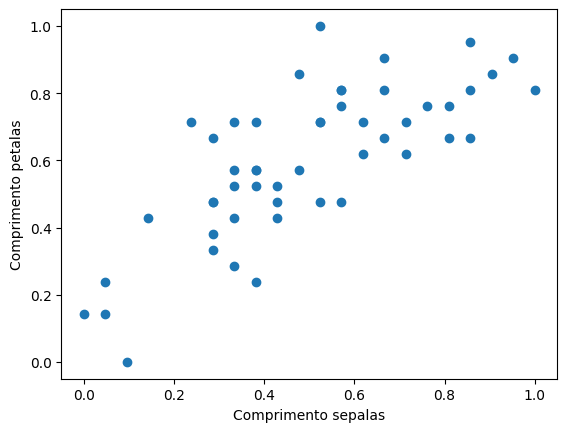

In [44]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()

plt.scatter(x_train,y_train)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')

### Exercício 1 - Criação do `x_train_bias`

faça o `x_train_bias` ser uma matriz com 1s na primeira coluna e x_train na segunda coluna.




Dica: você pode precisar da função [torch.cat](http://pytorch.org/docs/master/torch.html#torch.cat) e [torch.ones](http://pytorch.org/docs/master/torch.html#torch.ones).

In [45]:
# Exercício 1 - solução: construir x_train_bias com coluna de 1s + x_train

ones_col = torch.ones((n_samples, 1), dtype=torch.float32)
x_train_bias = torch.cat([ones_col, x_train], dim=1)

print(x_train_bias.shape, x_train_bias[:5])

torch.Size([50, 2]) tensor([[1.0000, 1.0000],
        [1.0000, 0.7143],
        [1.0000, 0.9524],
        [1.0000, 0.2857],
        [1.0000, 0.7619]])


In [46]:
# Verificação do exercício - Execute para testar sua implementação

print('x_train_bias é um tensor: {}'.format(print_assert(
    isinstance(x_train_bias, torch.FloatTensor)
)))

print('tamanho do x_train_bias: {}'.format(print_assert(
    x_train_bias.size() == torch.Size([50, 2])
)))

print('primeira coluna é só de uns: {}'.format(print_assert(
    (x_train_bias[:, 0] - torch.ones(n_samples)).sum() == 0
)))

print('segunda coluna é igual a x_train: {}'.format(print_assert(
    (x_train_bias[:, 1] - x_train.reshape(50)).sum() == 0
)))


x_train_bias é um tensor: OK!
tamanho do x_train_bias: OK!
primeira coluna é só de uns: OK!
segunda coluna é igual a x_train: OK!


## Modelo da rede

### Definição da classe

In [47]:
class Net():
    def __init__(self, n_in, n_out):
        self.w = torch.Tensor(n_out, n_in)
        self.w.uniform_(-0.1,0.1) #inicialização dos parâmetros

    def forward(self, x_bias):
        return x_bias.matmul(torch.t(self.w))


### Instanciando a rede

In [48]:
model = Net(2,1)

### Testando o predict da rede

In [49]:
# model.forward(torch.ones((4,2)))
# model.forward(torch.randn(4,2))

In [50]:
print("Saída com torch.ones:")
print(model.forward(torch.ones((4,2))))

print("\nSaída com torch.randn:")
print(model.forward(torch.randn(4,2)))


Saída com torch.ones:
tensor([[-0.1138],
        [-0.1138],
        [-0.1138],
        [-0.1138]])

Saída com torch.randn:
tensor([[-0.1034],
        [ 0.0705],
        [-0.0052],
        [-0.0229]])


## Treinamento

### Exercício 2 - Treinamento

Refaça o código de treinamento da rede, mas agora utilizando somente Tensores do PyTorch. Faça o mesmo procedimento que o notebook [LinearRegressionIrisNumPy](LinearRegressionIrisNumPy.ipynb). Para consultar as operações disponíveis no PyTorch use a [documentação do PyTorch](http://pytorch.org/docs/master/torch.html).

Funções que podem ser úteis:
- torch.t
- torch.mean
- torch.matmul

Epoch[20/100], loss: 0.022786
Epoch[40/100], loss: 0.021403
Epoch[60/100], loss: 0.021203
Epoch[80/100], loss: 0.021174
Epoch[100/100], loss: 0.021170


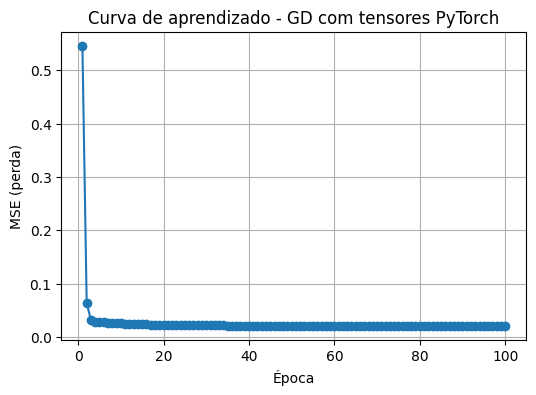

In [51]:
# Exercício 2 - Treinamento com PyTorch (tensores e álgebra matricial)
# Documentação: reproduzimos o treinamento por gradiente descendente (sem autograd),
# usando a forma matricial do gradiente do MSE:
#   grad = (2/M) * X^T (X w^T - y)   -> grad tem shape (2,1)
# Atualização: w <- w - eta * grad^T  (para casar com shape (1,2) de model.w)

num_epochs = 100
learning_rate = 0.5

loss_history = []  # para análise da curva de aprendizado

for epoch in range(num_epochs):
    # forward - predict
    y_pred = model.forward(x_train_bias)  # (M,1)

    # loss (MSE)
    loss = torch.mean((y_pred - y_train) ** 2)
    loss_history.append(float(loss.item()))

    # gradiente (forma matricial)
    resid = x_train_bias.mm(model.w.t()) - y_train   # (M,1)
    w_grad = (2.0 / n_samples) * x_train_bias.t().mm(resid)  # (2,1)

    # passo de gradiente descendente
    model.w = model.w - learning_rate * w_grad.t()   # (1,2)

    # verbose (a cada 20 épocas, como instruído)
    if (epoch + 1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'.format(epoch+1, num_epochs, loss.item()))

# Plot opcional da curva de perda (documentando novidade)
plt.figure(figsize=(6,4))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.xlabel('Época')
plt.ylabel('MSE (perda)')
plt.title('Curva de aprendizado - GD com tensores PyTorch')
plt.grid(True)
plt.show()

## Avaliação

### Predict

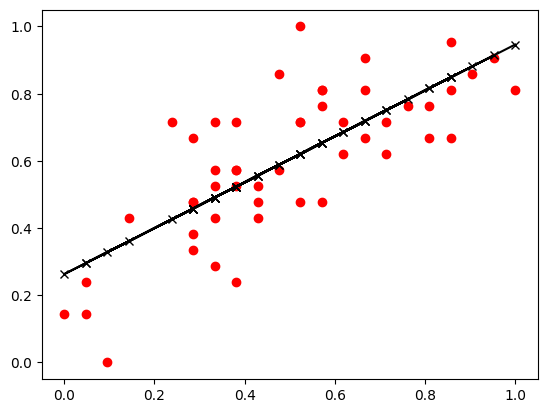

In [52]:
y_pred = model.forward(x_train_bias)
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original data')
plt.plot(x_train.numpy(), y_pred.numpy(), 'kx-', label='Fitting Line')
plt.show()

### Parâmetro treinado

In [53]:
print(model.w)

tensor([[0.2630, 0.6832]])


In [54]:
x_bias = x_train_bias
y = y_train
w_opt = (torch.inverse(x_bias.t().mm(x_bias)).mm(x_bias.t())).mm(y)
print(w_opt.t())

tensor([[0.2613, 0.6865]])
